In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
with open("data_splits/trumpClassifierText.txt", encoding = "utf-8") as f:
    trump = f.read()

In [5]:
with open("data_splits/othersClassifierText.txt", encoding = "utf-8") as f:
    others = f.read()

In [6]:
def splitTolenWords(text, nwords):
    words = text.split(" ")
    count = int(len(words)/nwords)
    sentences = [" ".join(words[(i*nwords):((i+1)*nwords)]) for i in range(count)]
    return(sentences)

In [7]:
## lets try to make <M> bleu 

import spacy
import en_core_web_sm

def unnameTextWithM(text):
    nlp = en_core_web_sm.load()
    doc = nlp(text)
    text = text
    for ent in reversed(doc.ents):
        text = text[:ent.start_char] + "<M>" + text[ent.end_char:] 
    return text

In [8]:
unnameTrump = unnameTextWithM(trump)
unnameOthers = unnameTextWithM(others)

In [9]:
trumpSentenceList = splitTolenWords(unnameTrump, 100)
OtherSentenceList = splitTolenWords(unnameOthers, 100)

In [10]:
import numpy as np

trump_labels = np.repeat(1,len(trumpSentenceList))
others_labels = np.repeat(0,len(OtherSentenceList))

In [11]:
sentences = np.concatenate([trumpSentenceList, OtherSentenceList], axis = 0)

In [41]:
labels = np.concatenate([trump_labels, others_labels], axis = 0)

In [42]:
from sklearn.model_selection import train_test_split

In [262]:
tv_x,test_x,tv_y,test_y = train_test_split(sentences, labels, test_size = 0.2)
train_x,valid_x,train_y,valid_y = train_test_split(tv_x, tv_y, test_size = 0.2)

In [269]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('clf', MultinomialNB()),
                     ])

text_clf.fit(train_x, train_y) 
print(classification_report(valid_y, text_clf.predict(valid_x)))

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('clf', GradientBoostingClassifier()),
                     ])

text_clf.fit(train_x, train_y) 
print(classification_report(valid_y, text_clf.predict(valid_x)))

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('clf', svm.SVC()),
                     ])

text_clf.fit(train_x, train_y) 
print(classification_report(valid_y, text_clf.predict(valid_x)))

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('clf', LogisticRegression()),
                     ])

text_clf.fit(train_x, train_y) 
print(classification_report(valid_y, text_clf.predict(valid_x)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        71
           1       0.94      0.94      0.94        84

    accuracy                           0.94       155
   macro avg       0.94      0.94      0.94       155
weighted avg       0.94      0.94      0.94       155

              precision    recall  f1-score   support

           0       0.88      0.83      0.86        71
           1       0.86      0.90      0.88        84

    accuracy                           0.87       155
   macro avg       0.87      0.87      0.87       155
weighted avg       0.87      0.87      0.87       155

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        71
           1       0.94      0.88      0.91        84

    accuracy                           0.90       155
   macro avg       0.90      0.91      0.90       155
weighted avg       0.91      0.90      0.90       155

              preci

In [271]:
from sklearn.model_selection import GridSearchCV

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('clf', MultinomialNB()),
                     ])

parameters = {'clf__alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
clf = GridSearchCV(text_clf, parameters)
clf.fit(tv_x, tv_y)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.9417427733556766
Best Params:  {'clf__alpha': 0.5}


In [272]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('clf', MultinomialNB(alpha = 0.5)),
                     ])

text_clf.fit(tv_x, tv_y)
print(classification_report(test_y, text_clf.predict(test_x)))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92        97
           1       0.91      0.94      0.92        96

    accuracy                           0.92       193
   macro avg       0.92      0.92      0.92       193
weighted avg       0.92      0.92      0.92       193



In [273]:
# final classifier will be trained on whole dataset 
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                    ('clf', MultinomialNB(alpha = 0.5)),
                     ])

text_clf.fit(sentences, labels)

Pipeline(steps=[('vect', CountVectorizer(stop_words='english')),
                ('clf', MultinomialNB(alpha=0.5))])

In [274]:
text = [" residents up for reelection usually ask if the country is better off than it was four years ago."]

In [275]:
text_clf.predict_proba(text)

array([[0.97689832, 0.02310168]])

In [276]:
import pickle
file_pi = open('classifiers/Textclassifier.obj', 'wb') 
pickle.dump(text_clf, file_pi)
file_pi.close()

# classifier based on POS

## data prep

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [13]:
nlp = en_core_web_sm.load()
def posTag(text):
    doc = nlp(str(text))
    pos = ""
    dep = ""
    for token in doc:
        pos = pos + token.pos_ + " "
        dep = dep + token.dep_ + " "
    return pos, dep

In [14]:
posSentences, detSentences = map(list,zip(*[posTag(sentence) for sentence in sentences]))
t1 = Tokenizer()
t1.fit_on_texts(posSentences)
t2 = Tokenizer()
t2.fit_on_texts(detSentences)
res1 = t1.texts_to_sequences(posSentences)
res2 = t2.texts_to_sequences(detSentences)
vocabsize1 = len(t1.word_index)+1
vocabsize2 = len(t2.word_index)+1

In [15]:
x1 = pad_sequences(
    res1, maxlen=200, dtype='int32', padding='post',
    truncating='post', value=0
)

x2 = pad_sequences(
    res2, maxlen=200, dtype='int32', padding='post',
    truncating='post', value=0
)

x = np.concatenate((x1[:,:,tf.newaxis],x2[:,:,tf.newaxis]), axis = 2)

In [16]:
y = to_categorical(labels)
print(x.shape, y.shape)

NameError: name 'labels' is not defined

In [282]:
tv_x,test_x,tv_y,test_y = train_test_split(x, y, test_size = 0.2)
train_x,valid_x,train_y,valid_y = train_test_split(tv_x, tv_y, test_size = 0.2)

In [22]:
vocabsize1

19

In [23]:
vocabsize2

44

## model 

In [17]:
visible1 = layers.Input(shape= (200,))
visible2 = layers.Input(shape= (200,))
x1 = layers.Embedding(input_dim=vocabsize1, output_dim=20)(visible1)
x2 = layers.Embedding(input_dim=vocabsize2, output_dim=20)(visible2)
x = layers.Concatenate(axis = 2)([x1, x2])
x = layers.Bidirectional(layers.LSTM(40, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(40))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(40,activation='relu')(x)
output = layers.Dense(2, activation='softmax')(x)
model = Model(inputs=[visible1, visible2], outputs=output)

In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 20)      380         input_3[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 20)      880         input_4[0][0]                    
_______________________________________________________________________________________

In [287]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [290]:
history = model.fit([train_x[:,:,0],train_x[:,:,1]], train_y,  epochs=200, validation_data=([valid_x[:,:,0],valid_x[:,:,1]], valid_y))

Epoch 1/200
20/20 [==============================] - 2s 100ms/step - loss: 0.6920 - accuracy: 0.5170 - val_loss: 0.6892 - val_accuracy: 0.4839
Epoch 2/200
20/20 [==============================] - 1s 40ms/step - loss: 0.6514 - accuracy: 0.6418 - val_loss: 0.5611 - val_accuracy: 0.7097
Epoch 3/200
20/20 [==============================] - 1s 40ms/step - loss: 0.5795 - accuracy: 0.7164 - val_loss: 0.5372 - val_accuracy: 0.7355
Epoch 4/200
20/20 [==============================] - 1s 40ms/step - loss: 0.5494 - accuracy: 0.7585 - val_loss: 0.5770 - val_accuracy: 0.7097
Epoch 5/200
20/20 [==============================] - 1s 40ms/step - loss: 0.5319 - accuracy: 0.7553 - val_loss: 0.5289 - val_accuracy: 0.7290
Epoch 6/200
20/20 [==============================] - 1s 40ms/step - loss: 0.5131 - accuracy: 0.7618 - val_loss: 0.5161 - val_accuracy: 0.7548
Epoch 7/200
20/20 [==============================] - 1s 41ms/step - loss: 0.5207 - accuracy: 0.7747 - val_loss: 0.5345 - val_accuracy: 0.7548
Epoch

20/20 [==============================] - 1s 37ms/step - loss: 0.1716 - accuracy: 0.9335 - val_loss: 0.8113 - val_accuracy: 0.8000
Epoch 116/200
20/20 [==============================] - 1s 36ms/step - loss: 0.1766 - accuracy: 0.9352 - val_loss: 0.9327 - val_accuracy: 0.8000
Epoch 117/200
20/20 [==============================] - 1s 36ms/step - loss: 0.1513 - accuracy: 0.9465 - val_loss: 0.8846 - val_accuracy: 0.7548
Epoch 118/200
20/20 [==============================] - 1s 36ms/step - loss: 0.1602 - accuracy: 0.9449 - val_loss: 1.0175 - val_accuracy: 0.8323
Epoch 119/200
20/20 [==============================] - 1s 37ms/step - loss: 0.1867 - accuracy: 0.9303 - val_loss: 0.7206 - val_accuracy: 0.7935
Epoch 120/200
20/20 [==============================] - 1s 36ms/step - loss: 0.1505 - accuracy: 0.9498 - val_loss: 0.8870 - val_accuracy: 0.8129
Epoch 121/200
20/20 [==============================] - 1s 36ms/step - loss: 0.1277 - accuracy: 0.9627 - val_loss: 1.5666 - val_accuracy: 0.7290
Epoch 

Epoch 172/200
20/20 [==============================] - 1s 37ms/step - loss: 0.0964 - accuracy: 0.9676 - val_loss: 1.1785 - val_accuracy: 0.7742
Epoch 173/200
20/20 [==============================] - 1s 36ms/step - loss: 0.0818 - accuracy: 0.9708 - val_loss: 1.3385 - val_accuracy: 0.7935
Epoch 174/200
20/20 [==============================] - 1s 37ms/step - loss: 0.0735 - accuracy: 0.9724 - val_loss: 1.1211 - val_accuracy: 0.7677
Epoch 175/200
20/20 [==============================] - 1s 37ms/step - loss: 0.1492 - accuracy: 0.9465 - val_loss: 1.0754 - val_accuracy: 0.8065
Epoch 176/200
20/20 [==============================] - 1s 37ms/step - loss: 0.1397 - accuracy: 0.9546 - val_loss: 1.0874 - val_accuracy: 0.7742
Epoch 177/200
20/20 [==============================] - 1s 37ms/step - loss: 0.0972 - accuracy: 0.9741 - val_loss: 1.2817 - val_accuracy: 0.7742
Epoch 178/200
20/20 [==============================] - 1s 37ms/step - loss: 0.1010 - accuracy: 0.9676 - val_loss: 1.2520 - val_accuracy:

In [291]:
val_acc_per_epoch = history.history['val_accuracy']
maxvalacc = max(val_acc_per_epoch)
print(maxvalacc)
best_epoch = val_acc_per_epoch.index(maxvalacc) + 1
print('Best epoch: %d' % (best_epoch,))

0.8451613187789917
Best epoch: 31


## model tuning 

In [292]:
import keras_tuner as kt

In [293]:
def model_builder(hp):
    
    visible1 = layers.Input(shape= (200,))
    visible2 = layers.Input(shape= (200,))
    embed_units = hp.Int('embed_units', min_value=10, max_value=20, step=2)
    x1 = layers.Embedding(input_dim=vocabsize1, output_dim=embed_units)(visible1)
    x2 = layers.Embedding(input_dim=vocabsize2, output_dim=embed_units)(visible2)
    x = layers.Concatenate(axis = 2)([x1, x2])
    rnn_units = hp.Int('rnn_units', min_value=10, max_value=40, step=3)
    x = layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(rnn_units))(x)
    x = layers.Dropout(0.5)(x)
    dense_units = hp.Int('dense_units', min_value=10, max_value=40, step=3)
    x = layers.Dense(dense_units,activation='relu')(x)
    output = layers.Dense(2, activation='softmax')(x)
    model = Model(inputs=[visible1, visible2], outputs=output)

    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [294]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='style_classifier')

In [295]:
tuner.search([train_x[:,:,0],train_x[:,:,1]], train_y,  epochs=200, validation_data=([valid_x[:,:,0],valid_x[:,:,1]], valid_y))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=2)[0]

print(f"""
The hyperparameter search is complete. embeding units  {best_hps.get('embed_units')}, rnn units  {best_hps.get('rnn_units')}, dense_units  {best_hps.get('dense_units')}.
""")


Trial 30 Complete [00h 00m 14s]
val_accuracy: 0.7870967984199524

Best val_accuracy So Far: 0.8258064389228821
Total elapsed time: 00h 05m 04s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. embeding units  18, rnn units  19, dense_units  34.



In [222]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit([train_x[:,:,0],train_x[:,:,1]], train_y, epochs=200, validation_data=([valid_x[:,:,0],valid_x[:,:,1]],valid_y))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/200
20/20 [==============================] - 2s 83ms/step - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6942 - val_accuracy: 0.4581
Epoch 2/200
20/20 [==============================] - 1s 36ms/step - loss: 0.6930 - accuracy: 0.5186 - val_loss: 0.6957 - val_accuracy: 0.4581
Epoch 3/200
20/20 [==============================] - 1s 36ms/step - loss: 0.6876 - accuracy: 0.5608 - val_loss: 0.6777 - val_accuracy: 0.6516
Epoch 4/200
20/20 [==============================] - 1s 35ms/step - loss: 0.6016 - accuracy: 0.7261 - val_loss: 0.5195 - val_accuracy: 0.7677
Epoch 5/200
20/20 [==============================] - 1s 35ms/step - loss: 0.6017 - accuracy: 0.7212 - val_loss: 0.5054 - val_accuracy: 0.7935
Epoch 6/200
20/20 [==============================] - 1s 35ms/step - loss: 0.5633 - accuracy: 0.7423 - val_loss: 0.5238 - val_accuracy: 0.7742
Epoch 7/200
20/20 [==============================] - 1s 35ms/step - loss: 0.4958 - accuracy: 0.7909 - val_loss: 0.5088 - val_accuracy: 0.7806
Epoch 

20/20 [==============================] - 1s 32ms/step - loss: 0.2328 - accuracy: 0.9060 - val_loss: 0.6548 - val_accuracy: 0.7742
Epoch 116/200
20/20 [==============================] - 1s 32ms/step - loss: 0.1673 - accuracy: 0.9335 - val_loss: 0.8637 - val_accuracy: 0.7935
Epoch 117/200
20/20 [==============================] - 1s 32ms/step - loss: 0.1423 - accuracy: 0.9465 - val_loss: 0.9023 - val_accuracy: 0.7742
Epoch 118/200
20/20 [==============================] - 1s 32ms/step - loss: 0.1321 - accuracy: 0.9465 - val_loss: 0.8946 - val_accuracy: 0.7677
Epoch 119/200
20/20 [==============================] - 1s 32ms/step - loss: 0.1795 - accuracy: 0.9222 - val_loss: 0.8595 - val_accuracy: 0.7935
Epoch 120/200
20/20 [==============================] - 1s 32ms/step - loss: 0.3475 - accuracy: 0.8574 - val_loss: 0.9420 - val_accuracy: 0.6452
Epoch 121/200
20/20 [==============================] - 1s 32ms/step - loss: 0.2780 - accuracy: 0.8752 - val_loss: 0.7692 - val_accuracy: 0.7871
Epoch 

Epoch 172/200
20/20 [==============================] - 1s 33ms/step - loss: 0.1116 - accuracy: 0.9660 - val_loss: 0.9722 - val_accuracy: 0.7871
Epoch 173/200
20/20 [==============================] - 1s 33ms/step - loss: 0.0711 - accuracy: 0.9838 - val_loss: 1.1632 - val_accuracy: 0.7548
Epoch 174/200
20/20 [==============================] - 1s 33ms/step - loss: 0.0770 - accuracy: 0.9822 - val_loss: 1.3404 - val_accuracy: 0.7484
Epoch 175/200
20/20 [==============================] - 1s 33ms/step - loss: 0.3061 - accuracy: 0.8849 - val_loss: 0.9754 - val_accuracy: 0.6968
Epoch 176/200
20/20 [==============================] - 1s 32ms/step - loss: 0.1446 - accuracy: 0.9449 - val_loss: 0.9398 - val_accuracy: 0.7548
Epoch 177/200
20/20 [==============================] - 1s 32ms/step - loss: 0.1716 - accuracy: 0.9368 - val_loss: 0.9732 - val_accuracy: 0.7613
Epoch 178/200
20/20 [==============================] - 1s 32ms/step - loss: 0.0911 - accuracy: 0.9724 - val_loss: 0.9895 - val_accuracy:

In [296]:
checkpoint_filepath = 'classifiers/temp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [297]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit([train_x[:,:,0],train_x[:,:,1]], train_y, epochs=100, validation_data=([valid_x[:,:,0],valid_x[:,:,1]],valid_y), callbacks=[model_checkpoint_callback])

Epoch 1/100
20/20 [==============================] - 20s 999ms/step - loss: 0.6928 - accuracy: 0.4765 - val_loss: 0.6941 - val_accuracy: 0.4839
Epoch 2/100
20/20 [==============================] - 1s 36ms/step - loss: 0.6921 - accuracy: 0.5251 - val_loss: 0.6936 - val_accuracy: 0.4839
Epoch 3/100
20/20 [==============================] - 19s 944ms/step - loss: 0.6880 - accuracy: 0.5462 - val_loss: 0.6832 - val_accuracy: 0.6645
Epoch 4/100
20/20 [==============================] - 20s 1s/step - loss: 0.6738 - accuracy: 0.5964 - val_loss: 0.6371 - val_accuracy: 0.6774
Epoch 5/100
20/20 [==============================] - 20s 991ms/step - loss: 0.5545 - accuracy: 0.7439 - val_loss: 0.6104 - val_accuracy: 0.7161
Epoch 6/100
20/20 [==============================] - 1s 36ms/step - loss: 0.6095 - accuracy: 0.6661 - val_loss: 0.5862 - val_accuracy: 0.6968
Epoch 7/100
20/20 [==============================] - 19s 956ms/step - loss: 0.5560 - accuracy: 0.7407 - val_loss: 0.5433 - val_accuracy: 0.7355

In [298]:
from tensorflow.keras.models import load_model
model = load_model(checkpoint_filepath)

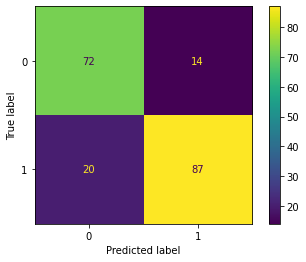

In [299]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(np.argmax(test_y, axis = 1), np.argmax(model.predict([test_x[:,:,0], test_x[:,:,1]]), axis = 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [300]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_y, axis = 1), np.argmax(model.predict([test_x[:,:,0], test_x[:,:,1]]), axis = 1)))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        86
           1       0.86      0.81      0.84       107

    accuracy                           0.82       193
   macro avg       0.82      0.83      0.82       193
weighted avg       0.83      0.82      0.82       193



## train final model on test and validation datasets and validate on test data_set 

In [301]:
checkpoint_filepath = 'classifiers/temp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [302]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit([tv_x[:,:,0], tv_x[:,:,1]], tv_y, epochs=100, validation_data=([test_x[:,:,0], test_x[:,:,1]], test_y), callbacks=[model_checkpoint_callback])

Epoch 1/100
25/25 [==============================] - 19s 740ms/step - loss: 0.6934 - accuracy: 0.4806 - val_loss: 0.6941 - val_accuracy: 0.4456
Epoch 2/100
25/25 [==============================] - 19s 771ms/step - loss: 0.6885 - accuracy: 0.5596 - val_loss: 0.6789 - val_accuracy: 0.6321
Epoch 3/100
25/25 [==============================] - 21s 827ms/step - loss: 0.5774 - accuracy: 0.7370 - val_loss: 0.5358 - val_accuracy: 0.7668
Epoch 4/100
25/25 [==============================] - 20s 801ms/step - loss: 0.4875 - accuracy: 0.7953 - val_loss: 0.4155 - val_accuracy: 0.8238
Epoch 5/100
25/25 [==============================] - 19s 750ms/step - loss: 0.4481 - accuracy: 0.8070 - val_loss: 0.4085 - val_accuracy: 0.8446
Epoch 6/100
25/25 [==============================] - 1s 36ms/step - loss: 0.4688 - accuracy: 0.7953 - val_loss: 0.3996 - val_accuracy: 0.8238
Epoch 7/100
25/25 [==============================] - 1s 35ms/step - loss: 0.3950 - accuracy: 0.8277 - val_loss: 0.3657 - val_accuracy: 0.8

In [303]:
from tensorflow.keras.models import load_model
model = load_model(checkpoint_filepath)

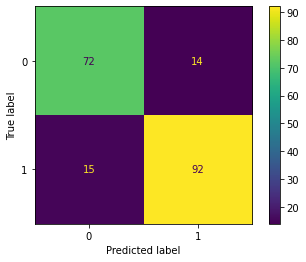

In [304]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(np.argmax(test_y, axis = 1), np.argmax(model.predict([test_x[:,:,0], test_x[:,:,1]]), axis = 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [305]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_y, axis = 1), np.argmax(model.predict([test_x[:,:,0], test_x[:,:,1]]), axis = 1)))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        86
           1       0.87      0.86      0.86       107

    accuracy                           0.85       193
   macro avg       0.85      0.85      0.85       193
weighted avg       0.85      0.85      0.85       193



## add to pipe and save 

In [306]:
def POSclassifier(sentences):
    posSentences, detSentences = map(list,zip(*[posTag(sentence) for sentence in sentences]))
    res1 = t1.texts_to_sequences(posSentences)
    res2 = t2.texts_to_sequences(detSentences)
    vocabsize1 = len(t1.word_index)+1
    vocabsize2 = len(t2.word_index)+1
    
    x1 = pad_sequences(
    res1, maxlen=200, dtype='int32', padding='post',
    truncating='post', value=0
    )

    x2 = pad_sequences(
        res2, maxlen=200, dtype='int32', padding='post',
        truncating='post', value=0
    )
    
    results = model.predict([x1, x2])
    return results

In [311]:
POSclassifier(["testing methos to predict something"])

array([[0.27068743, 0.72931254]], dtype=float32)

In [349]:


class PosClassifier:
    
    
    def __init__(self):
        self.nlp = en_core_web_sm.load()
        
        objectRep = open('classifiers/tok1.obj', "rb")
        self.t1 = pickle.load(objectRep)
        objectRep.close()

        objectRep = open('classifiers/tok2.obj', "rb")
        self.t2 = pickle.load(objectRep)
        objectRep.close()
        
        self.model = tf.keras.models.load_model("classifiers/kerasModel")


        
    def posTag(self, text):
        doc = self.nlp(str(text))
        pos = ""
        dep = ""
        for token in doc:
            pos = pos + token.pos_ + " "
            dep = dep + token.dep_ + " "
        return pos, dep
    
    def predict(self, sentences):
        posSentences, detSentences = map(list,zip(*[self.posTag(sentence) for sentence in sentences]))
        res1 = self.t1.texts_to_sequences(posSentences)
        res2 = self.t2.texts_to_sequences(detSentences)

        x1 = pad_sequences(
        res1, maxlen=200, dtype='int32', padding='post',
        truncating='post', value=0
        )

        x2 = pad_sequences(
            res2, maxlen=200, dtype='int32', padding='post',
            truncating='post', value=0
        )

        results = self.model.predict([x1, x2])
        return results
        
        

In [347]:
Posclassifier = PosClassifier()
Posclassifier.predict(["testing methos to predict something"])

array([[0.27068743, 0.72931254]], dtype=float32)

In [333]:
import dill as pickle
file_pi = open('classifiers/tok1.obj', 'wb') 
pickle.dump(t1, file_pi)
file_pi.close()

file_pi = open('classifiers/tok2.obj', 'wb') 
pickle.dump(t2, file_pi)
file_pi.close()

file_pi = open('classifiers/tok2.obj', 'wb') 
pickle.dump(t2, file_pi)
file_pi.close()

In [350]:
import dill as pickle
file_pi = open('classifiers/POSclassifier4.obj', 'wb') 
pickle.dump(PosClassifier, file_pi)
file_pi.close()

In [343]:
model.save("classifiers/kerasModel")

INFO:tensorflow:Assets written to: classifiers/kerasModel\assets
